In [1]:
#@title
#Tanveer_1728042
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
#@title
downloaded = drive.CreateFile({'id':'1LY2kUaXY62IxGXsKziS-TZsxBnIFwCHK'}) # replace the id with id of file you want to access
downloaded.GetContentFile('kaggle.json') 

In [3]:
#@title
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#@title
!kaggle datasets download -d toxicmender/20bn-jester

100% 11.9G/11.9G [04:50<00:00, 31.9MB/s]
100% 11.9G/11.9G [04:50<00:00, 44.2MB/s]


In [5]:
#@title
from zipfile import ZipFile
file_name = "20bn-jester.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tqdm import tqdm
import os
import gc
import theano
import math
import seaborn as sbn
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,AveragePooling2D,AveragePooling3D
from keras.layers import Dense, GlobalAveragePooling3D,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import SGD, RMSprop, Adadelta,Adam,Adamax
from keras.utils import np_utils, generic_utils
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.layers.convolutional_recurrent import ConvLSTM2D

**Making smaller set**

The classes (labels) we want to use

In [2]:
LABELS = {
    "Swiping Right": 0,
    "Swiping Left": 1,
    "Thumb Up": 2,
    "Drumming Fingers": 3,
    "No Gesture": 4
}

**Loading Data**

In [3]:
BASE_PATH = '/content'
TRAIN_DATA_CSV = BASE_PATH + '/Train.csv'
TEST_DATA_CSV = BASE_PATH + '/Test.csv'
VAL_DATA_CSV = BASE_PATH + '/Validation.csv'

TRAIN_SAMPLES_PATH = BASE_PATH + '/Train/'
TEST_SAMPLES_PATH = BASE_PATH + '/Test/'
VAL_SAMPLES_PATH = BASE_PATH + '/Validation/'

Training targets, you can use your custom csv file if you already created it before

In [4]:
targets = pd.read_csv(TRAIN_DATA_CSV)
targets = targets[targets['label'].isin(LABELS.keys())]
targets['label'] = targets['label'].map(LABELS)
targets = targets[['video_id', 'label']]
targets = targets.reset_index()
targets

,index,video_id,label
0,2,6,3
1,16,51,0
2,34,95,0
3,35,100,0
4,39,107,1
...,...,...,...
7146,50408,148061,0
7147,50410,148070,0
7148,50412,148077,3
7149,50416,148085,3


Validation targets, you can use your custom csv file if you already created it before

In [5]:
targets_validation = pd.read_csv(VAL_DATA_CSV)
targets_validation = targets_validation[targets_validation['label'].isin(LABELS.keys())]
targets_validation['label'] = targets_validation['label'].map(LABELS)
targets_validation = targets_validation[['video_id', 'label']]
targets_validation = targets_validation.reset_index()
targets_validation

,index,video_id,label
0,4,96,0
1,6,168,3
2,17,420,2
3,26,610,2
4,30,742,0
...,...,...,...
968,7010,147180,2
969,7019,147378,1
970,7020,147395,2
971,7031,147716,3


**Preprocessing**

In [6]:
# image specification
img_rows,img_cols=64, 64 

In [7]:
def rgb2gray(rgb):
    """
    Converts numpy array of RGB to grayscale
    """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [8]:
def resize_frame(frame):
    """
    Resizes frames to (64, 64)
    """
    frame = img.imread(frame)
    frame = cv2.resize(frame, (img_rows,img_cols),interpolation=cv2.INTER_AREA)
    return frame

The videos do not have the same number of frames, here we try to unify.

In [9]:
hm_frames = 30 # number of frames
def get_unify_frames(path):
    """
    Unifies number of frames for each training
    """
    offset = 0
    # pick frames
    frames = os.listdir(path)
    frames_count = len(frames)
    # unify number of frames 
    if hm_frames > frames_count:
        # duplicate last frame if video is shorter than necessary
        frames += [frames[-1]] * (hm_frames - frames_count)
    elif hm_frames < frames_count:
        # If there are more frames, then sample starting offset
        # diff = (frames_count - hm_frames)
        # offset = diff-1 
        frames = frames[0:hm_frames]
    return frames

Adjust data

In [10]:
# Adjust training data
train_targets = [] # training targets 
test_targets = [] # testing targets

new_frames = [] # training data after resize & unify
new_frames_test = [] # testing data after resize & unify

for idx, row in tqdm(targets.iterrows(), total=len(targets)):
    if idx % 4 == 0:
        continue
    
    partition = [] # one training
    # Frames in each folder
    frames = get_unify_frames(TRAIN_SAMPLES_PATH + str(row['video_id']))
    if len(frames) == hm_frames: # just to be sure
        for frame in frames:
            frame = resize_frame(TRAIN_SAMPLES_PATH + str(row['video_id']) + '/' + frame)
            partition.append(rgb2gray(frame))
            if len(partition) == 15: # partition each training on two trainings.
                if idx % 6 == 0:
                    new_frames_test.append(partition) # append each partition to training data
                    test_targets.append(row['label'])
                else:
                    new_frames.append(partition) # append each partition to test data
                    train_targets.append(row['label'])
                partition = []

train_data = np.asarray(new_frames, dtype=np.float16)

del new_frames[:]
del new_frames


test_data = np.asarray(new_frames_test, dtype=np.float16)
del new_frames_test[:]
del new_frames_test

gc.collect()

100%|██████████| 7151/7151 [03:31<00:00, 33.83it/s]


11

In [11]:
# we do the same for the validation data
cv_targets = []
new_frames_cv = []
for idx, row in tqdm(targets_validation.iterrows(), total=len(targets_validation)):
    if idx % 4 == 0:
        continue

    partition = []
    # Frames in each folder
    frames = get_unify_frames(VAL_SAMPLES_PATH+str(row["video_id"]))
    for frame in frames:
        frame = resize_frame(VAL_SAMPLES_PATH+str(row["video_id"])+'/'+frame)
        partition.append(rgb2gray(frame))
        if len(partition) == 15:
            new_frames_cv.append(partition)
            cv_targets.append(row['label'])
            partition = []
                
cv_data = np.array(new_frames_cv, dtype=np.float16)
del new_frames_cv[:]
del new_frames_cv
gc.collect()

100%|██████████| 973/973 [00:30<00:00, 31.78it/s]


0

In [13]:
cv_data.shape

(2192, 15, 64, 64)

In [ ]:
print(f"Training = {len(train_data)}/{len(train_targets)} samples/labels")
print(f"Test = {len(test_data)}/{len(test_targets)} samples/labels")
print(f"Validation = {len(cv_data)}/{len(cv_targets)} samples/labels")

Training = 13146/13146 samples/labels
Test = 1644/1644 samples/labels
Validation = 2068/2068 samples/labels


In [12]:
nb_classes = 5
patch_size = 15    # img_depth or number of frames used for each video

In [19]:
num_samples = len(train_data)
print(num_samples)

14324


Feature scaling

In [13]:
# Normalisation: training
print('old mean', train_data.mean())

scaler = StandardScaler(copy=False)
scaled_images  = scaler.fit_transform(train_data.reshape(-1, 15*64*64))
del train_data
print('new mean', scaled_images.mean())

scaled_images  = scaled_images.reshape(-1, 15, 64, 64, 1)
print(scaled_images.shape)

old mean 114.6
new mean 1e-07
(9534, 15, 64, 64, 1)


In [14]:
# Normalisation: test
print('old mean', test_data.mean())

scaler = StandardScaler(copy=False)
scaled_images_test = scaler.fit_transform(test_data.reshape(-1, 15*64*64))
del test_data
print('new mean', scaled_images_test.mean())

scaled_images_test = scaled_images_test.reshape(-1, 15, 64, 64, 1)
print(scaled_images_test.shape)

old mean 115.5
new mean -3e-07
(1192, 15, 64, 64, 1)


In [15]:
# Normalisation: validation
print('old mean', cv_data.mean())

scaler = StandardScaler(copy=False)
scaled_images_cv  = scaler.fit_transform(cv_data.reshape(-1, 15*64*64))
del cv_data
print('new mean',scaled_images_cv.mean())

scaled_images_cv  = scaled_images_cv.reshape(-1, 15, 64, 64, 1)
print(scaled_images_cv.shape)

old mean 111.5
new mean -2e-07
(1458, 15, 64, 64, 1)


In [16]:
del scaler

**Make sets**

In [17]:
y_train = np.array(train_targets, dtype=np.int8)
y_test = np.array(test_targets, dtype=np.int8)
y_val = np.array(cv_targets, dtype=np.int8)
del train_targets
del test_targets
del cv_targets

In [18]:
x_train = scaled_images
x_test = scaled_images_test
x_val = scaled_images_cv
del scaled_images
del scaled_images_test
del scaled_images_cv

In [19]:
gc.collect()

0

**Model**

In [22]:
# Define model
model = Sequential()

model.add(Conv3D(8, 
                 kernel_size=(3,3,3), 
                 input_shape=(patch_size, img_cols, img_rows, 1),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,1,1)))
#model.add(Dropout(0.25))

model.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

model.add(Conv3D(32, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
#model.add(Dropout(0.25))

model.add(Conv3D(64, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(5, activation='softmax'))

In [23]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 15, 64, 64, 8)     224       
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 64, 64, 8)     32        
_________________________________________________________________
activation_8 (Activation)    (None, 15, 64, 64, 8)     0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 64, 64, 8)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 15, 64, 64, 16)    3472      
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 64, 64, 16)    64        
_________________________________________________________________
activation_9 (Activation)    (None, 15, 64, 64, 16)   

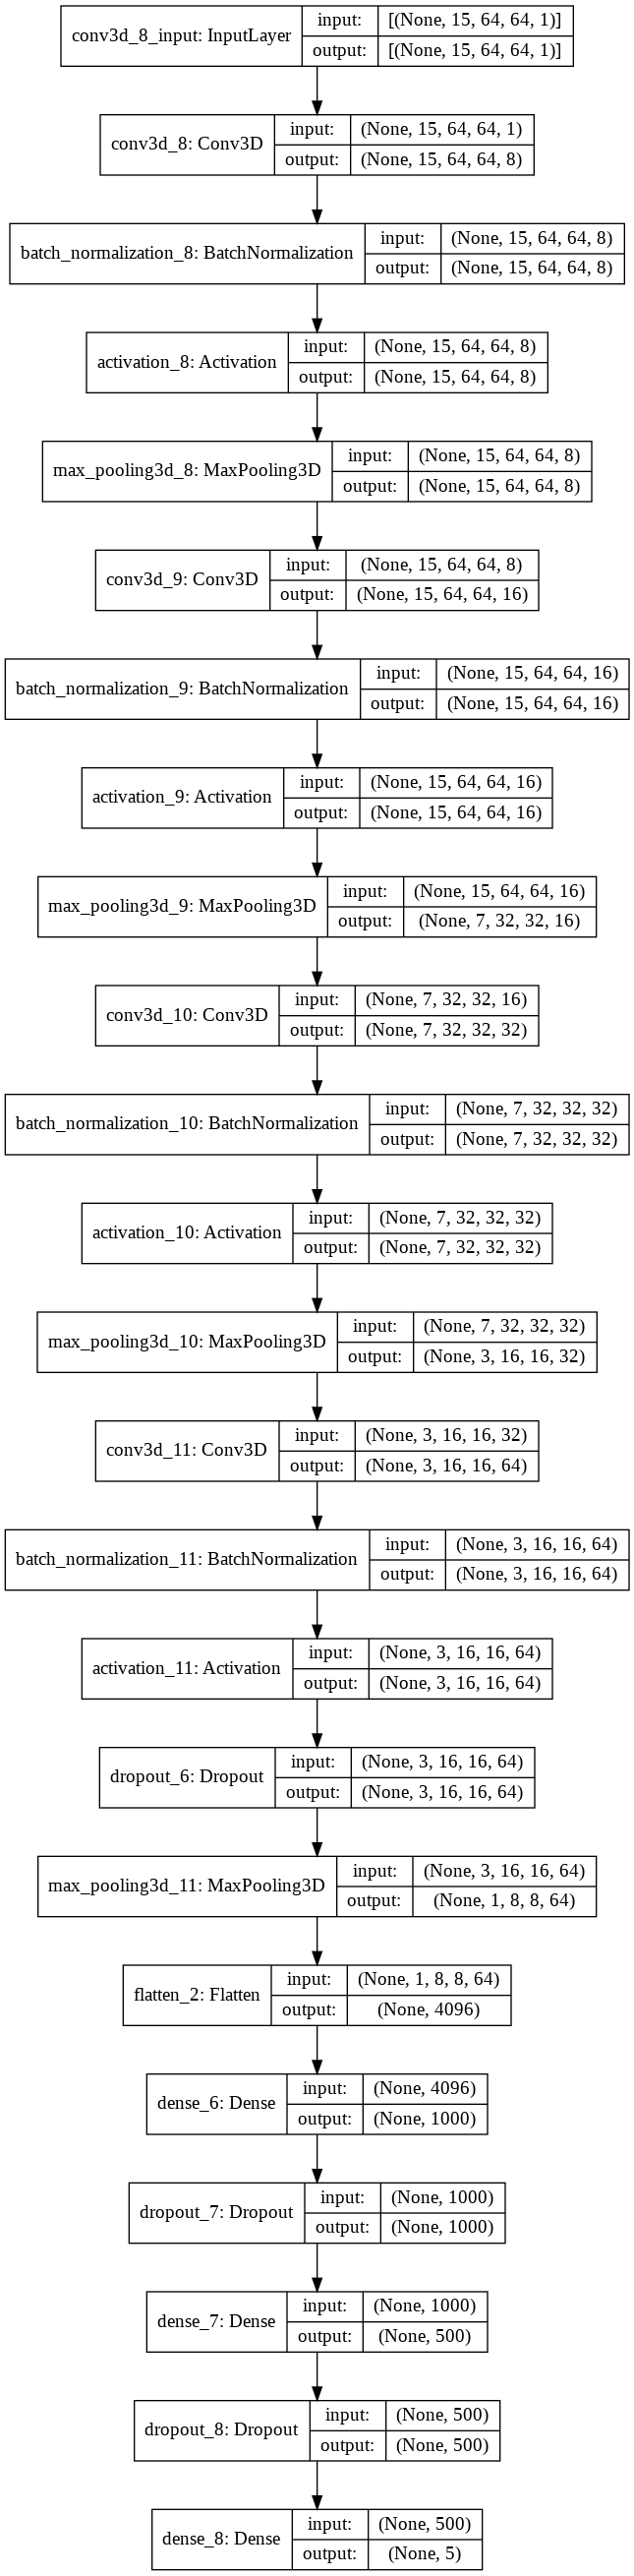

In [24]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True,
               to_file=os.path.join('model.png'))

In [25]:
sgd = SGD(lr=0.005,  momentum=0.9,nesterov=False)
#rms = RMSprop(decay=1e-6)
#ada = Adadelta(lr=0.1,decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=sgd,
              #optimizer=ada,
              metrics=['acc'])

In [26]:
# Split the data
X_train_new, X_val_new, y_train_new,y_val_new = train_test_split(x_train, y_train, test_size=0.2, random_state=20)


In [27]:
import os
#os.chdir('///home/jovyan/program/DL/11_1下tensorflow_simpson')
save_dir = os.path.join(os.getcwd(),'Saved_Model')
print(os.getcwd())
model_name = "3DCNN"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'val_acc', 
                            save_best_only=True, verbose=1)
#earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=50, verbose =1)

/content


**Start Running**

In [28]:
batch_size = 80
nb_epoch = 100
#steps_per_epoch=int((len(x_train))/batch_size)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.05, 
                               cooldown=0, patience=10, min_lr=0.005/(2^4),verbose=1)
#lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
hist = model.fit(
    X_train_new,
    y_train_new,
    validation_data=(X_val_new,y_val_new),
    batch_size = batch_size,
    epochs = nb_epoch,
    shuffle=True,
    callbacks=[checkpoint,lr_reducer]
    )

Epoch 1/100
96/96 [==============================] - 45s 376ms/step - loss: 1.9791 - acc: 0.2959 - val_loss: 1.2623 - val_acc: 0.4730

Epoch 00001: val_acc improved from -inf to 0.47299, saving model to /content/Saved_Model/3DCNN
INFO:tensorflow:Assets written to: /content/Saved_Model/3DCNN/assets
Epoch 2/100
96/96 [==============================] - 35s 369ms/step - loss: 1.0524 - acc: 0.4944 - val_loss: 0.9758 - val_acc: 0.6009

Epoch 00002: val_acc improved from 0.47299 to 0.60094, saving model to /content/Saved_Model/3DCNN
INFO:tensorflow:Assets written to: /content/Saved_Model/3DCNN/assets
Epoch 3/100
96/96 [==============================] - 36s 379ms/step - loss: 0.8447 - acc: 0.6184 - val_loss: 0.7704 - val_acc: 0.6780

Epoch 00003: val_acc improved from 0.60094 to 0.67803, saving model to /content/Saved_Model/3DCNN
INFO:tensorflow:Assets written to: /content/Saved_Model/3DCNN/assets
Epoch 4/100
96/96 [==============================] - 37s 384ms/step - loss: 0.6937 - acc: 0.7024 

38/38 [==============================] - 2s 39ms/step - loss: 0.3653 - acc: 0.9211
Accuracy:92.1140968799591%


Text(0, 0.5, 'Loss')

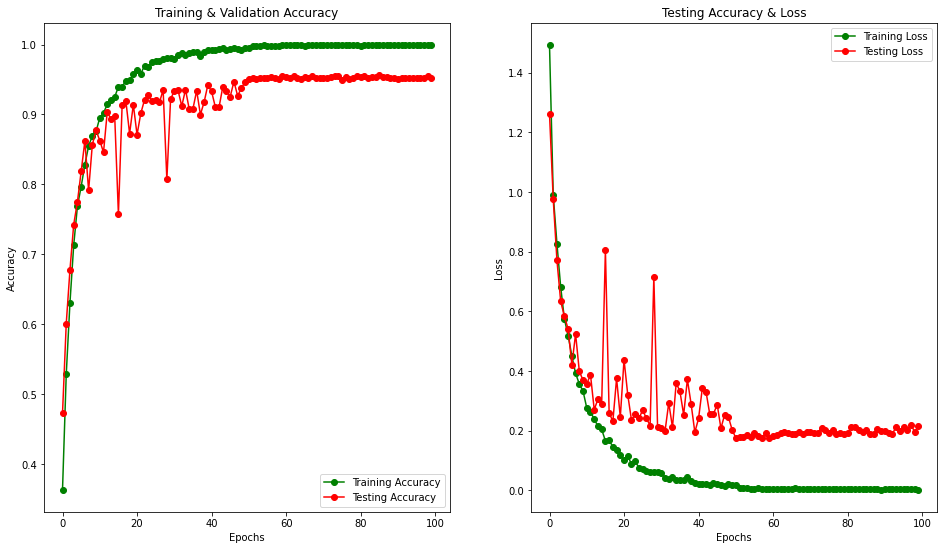

In [29]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc*100)+"%")
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['acc']
train_loss = hist.history['loss']
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc,'go-',label='Training Accuracy')
ax[0].plot(epochs , val_acc,'ro-',label='Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss,'g-o',label='Training Loss')
ax[1].plot(epochs , val_loss,'r-o',label='Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

In [30]:
model.save_weights('/content/Saved_Model/wieght.tf', save_format='tf')

**Make Predictions**

In [31]:
x_test.shape

(1192, 15, 64, 64, 1)

In [32]:
y_test.shape

(1192,)

In [33]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3], dtype=int8), array([284, 318, 296, 294]))

Make Prediction

In [34]:
y_pred = model.predict(x_test)

In [35]:
pred=np.argmax(y_pred,axis=1)


In [36]:
y_pred.shape

(1192, 5)

In [37]:
y_pred = np.argmax(y_pred, axis=-1)
y_pred.shape

(1192,)

In [38]:
y_pred

array([1, 1, 2, ..., 1, 1, 1])

**Analysis**

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [40]:
labels = list(LABELS.keys())
labels

['Swiping Right', 'Swiping Left', 'Thumb Up', 'Drumming Fingers', 'No Gesture']

In [42]:
from sklearn.metrics import classification_report,confusion_matrix
classes = ["labels "+str(i) for i in range(4)]
print(classification_report(y_test, y_pred,target_names=classes))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    labels 0       0.94      0.92      0.93       284
    labels 1       0.92      0.93      0.92       318
    labels 2       0.86      0.97      0.91       296
    labels 3       0.97      0.87      0.92       294

    accuracy                           0.92      1192
   macro avg       0.92      0.92      0.92      1192
weighted avg       0.92      0.92      0.92      1192

Accuracy: 0.9211409395973155
[[262  14   8   0]
 [ 11 295   8   4]
 [  3   4 286   3]
 [  2   8  29 255]]


**1. Confusion Matrix**

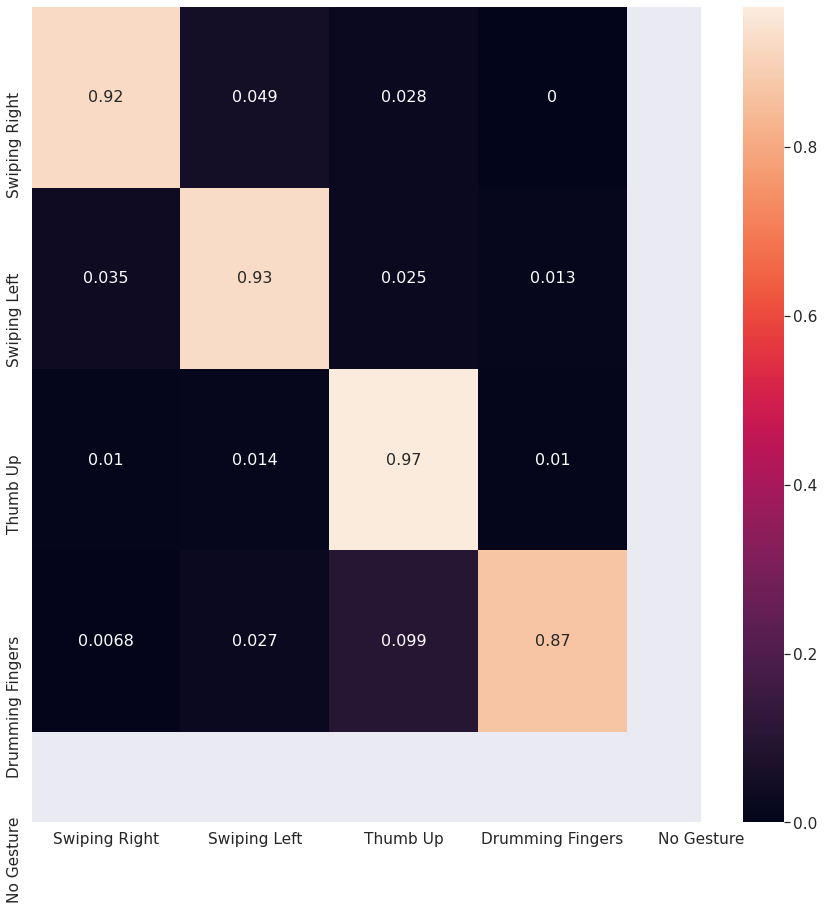

In [45]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
df_cm = pd.DataFrame(cm, range(4), range(4))
plt.figure(figsize=(15,15))
sbn.set(font_scale=1.4) # for label size
sbn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)

plt.show()

**2. Accuracy**

In [46]:
accuracy_score(y_test, y_pred)

0.9211409395973155

**3. Precision**

In [47]:
precision_score(y_test, y_pred, average='macro')

0.9246949848867343

**4. Recall**

In [48]:
recall_score(y_test, y_pred, average='macro')

0.9209428305585436

**5. F1**

In [49]:
f1_score(y_test, y_pred, average='macro')

0.9213122285807052

In [50]:
!cp -r "/content/Saved_Model-v2" "/content/drive/MyDrive"